In [1]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy import interpolate
import numpy as np
import scipy
import copy
import pickle
import math
import os
import datetime as dt 

import heliopy.data.spice as spicedata
import heliopy.spice as spice
from astropy.coordinates import SkyCoord
import astropy.units as u

from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable

from archimedes_sprial import cmap_spiral, compute_phi_shift_forward
from hux_propagation import *
from carrington_dates import * 

# matplotlib fontsize
%matplotlib notebook
%matplotlib inline
fs1=12
plt.rcParams['savefig.facecolor'] = 'white'

In [2]:
from heliopy.data import solo
from heliopy.data import omni

## Solar Orbiter (SolO)
The routines in this module can be used to load data from the Solar Orbiter (SOLO) mission. SolO was launched in February 9, 2020, 8:03 PM PST.


Instruments
-----------------
Magnetometer (MAG)

Energetic Particle Detector (EPD)

Radio and Plasma Waves (RPW)

Solar Wind Plasma Analyser (SWA)


In [3]:
case_study = "cr2233"
starttime, endtime, cr = get_time_interval(case_study)

In [32]:
starttime

datetime.datetime(2020, 7, 15, 0, 0)

In [33]:
endtime = dt.datetime(2020, 10, 27)

In [34]:
# example MAG-RTN-NORMAL // SWA-EAS-SS LL02 // SWA-PAS-MOM L1
# see https://www.davidstansby.com/soda/ for dates with available data

solo_data = solo.download(starttime, endtime, 'SWA-PAS-MOM', 'L1')

100.0% 212992 / 206179


100.0% 1351680 / 1349647


100.0% 1638400 / 1637451


100.0% 1351680 / 1349647


100.0% 1638400 / 1637451


100.0% 1638400 / 1637451


100.0% 892928 / 888763


100.0% 32768 / 32259


100.0% 720896 / 715999


100.0% 1638400 / 1637451


100.0% 1351680 / 1349647


100.0% 1638400 / 1637451


100.0% 1638400 / 1637451


100.0% 1638400 / 1637451


100.0% 1638400 / 1637451


100.0% 1351680 / 1349647


100.0% 1622016 / 1620883


100.0% 1351680 / 1349647


100.0% 1638400 / 1637451


100.0% 1638400 / 1637451


100.0% 1466368 / 1464779


100.0% 557056 / 551215


100.0% 1638400 / 1637451


100.0% 1638400 / 1637451


100.0% 1351680 / 1349647


100.0% 1613824 / 1612675


100.0% 1351680 / 1349647


100.0% 1638400 / 1637451


100.0% 737280 / 732427


100.0% 32768 / 32259


100.0% 32768 / 32259


100.0% 32768 / 32259


100.0% 32768 / 32259


100.0% 32768 / 32259


100.0% 32768 / 32259


100.0% 1638400 / 1637451


100.0% 557056 / 551215


100.0% 1409024 / 1407331


100.0% 1638400 / 1637451


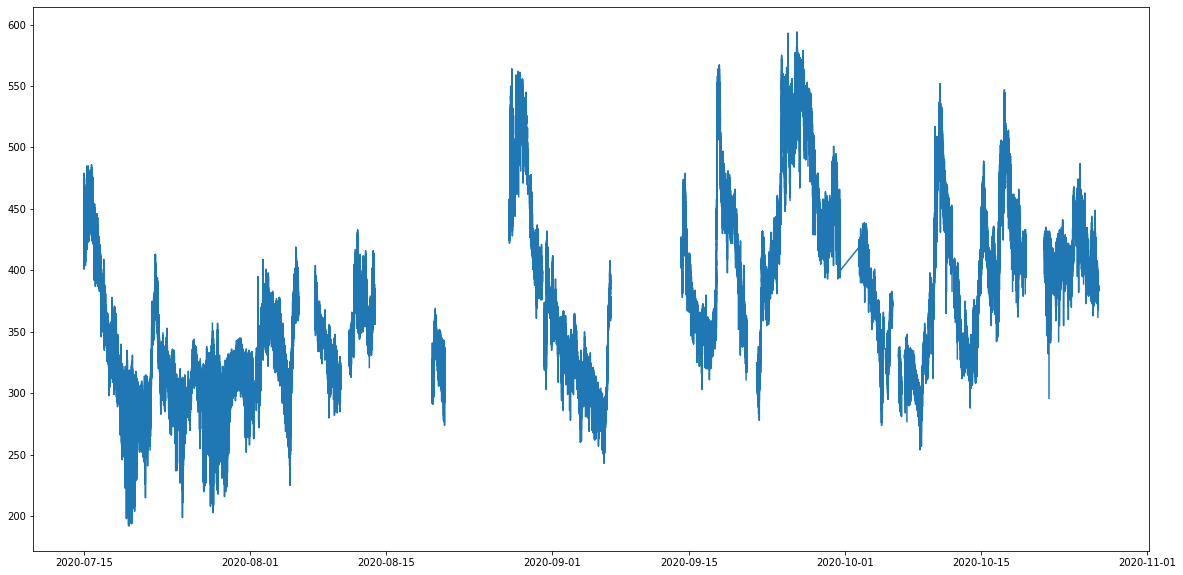

In [35]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(solo_data.data["velocity_0"])

In [36]:
solo_data.data

,CCSDS_time,SCET,sample,validity,sum_PAS,data_validity_flag,density,velocity_0,velocity_1,velocity_2,pressure_0,pressure_1,pressure_2,pressure_3,pressure_4,pressure_5,temperature
Time,,,,,,,,,,,,,,,,,
2020-07-15 00:00:03.041183104,6.480865e+08,648086380.5,5,0,2,1,16.500000,411.0,66.0,25.0,3.271409e-17,3.269171e-17,3.268887e-17,1.901152e-27,3.801864e-27,2.044730e-18,12.368540
2020-07-15 00:00:07.041183104,6.480865e+08,648086384.5,6,0,2,1,16.299999,411.0,65.0,21.0,6.537206e-17,3.269273e-17,3.268931e-17,1.901260e-27,3.801980e-27,2.044626e-18,16.688786
2020-07-15 00:00:11.041183104,6.480865e+08,648086388.5,7,0,2,1,15.900000,411.0,64.0,23.0,6.536964e-17,3.269208e-17,3.268772e-17,1.901754e-27,3.801918e-27,4.085641e-18,17.108017
2020-07-15 00:00:15.041183104,6.480865e+08,648086392.5,8,0,2,1,16.000000,409.0,63.0,20.0,6.537400e-17,3.269071e-17,3.268634e-17,1.901121e-27,3.801388e-27,2.044040e-18,17.001303
2020-07-15 00:00:19.041183104,6.480865e+08,648086396.5,9,0,2,1,16.000000,409.0,63.0,21.0,6.536969e-17,3.269071e-17,3.268878e-17,1.901480e-27,3.801534e-27,2.044256e-18,17.001060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26 23:59:41.546761600,6.570720e+08,657071944.5,7,0,2,1,7.600000,383.0,20.0,0.0,1.634249e-17,2.044683e-18,4.086568e-18,2.042891e-18,5.110578e-19,1.277754e-19,6.152034
2020-10-26 23:59:45.546761600,6.570720e+08,657071948.5,8,0,2,1,7.400000,385.0,20.0,0.0,1.634364e-17,4.085929e-18,4.086366e-18,5.111259e-19,5.110792e-19,1.597357e-20,6.892453
2020-10-26 23:59:49.546761600,6.570720e+08,657071952.5,9,0,2,1,7.600000,384.0,21.0,0.0,1.634230e-17,4.085571e-18,4.086163e-18,1.022226e-18,1.276959e-19,6.386809e-20,6.710552


In [37]:
omni_data = omni.h0_mrg1hr(starttime, endtime)

In [38]:
omni_data.data

,Epoch_1800,Rot1800,IMF1800,PLS1800,IMF_PTS1800,PLS_PTS1800,ABS_B1800,F1800,THETA_AV1800,PHI_AV1800,...,F10_INDEX,KP,DST,AE,AP_INDEX,AL_INDEX,AU_INDEX,PC_N_INDEX,Solar_Lyman_alpha,Proton_QI
Time,,,,,,,,,,,,,,,,,,,,,
2020-07-15 01:00:00,6.376200e+13,2550,51,52,60,35,5.7,5.2,20.799999,143.300003,...,70.599998,0,-14,9999,0,99999,99999,NaN,0.006240,0.0302
2020-07-15 02:00:00,6.376200e+13,2550,51,52,63,35,5.8,5.1,11.600000,115.300003,...,70.599998,0,-13,9999,0,99999,99999,NaN,0.006240,0.0359
2020-07-15 03:00:00,6.376200e+13,2550,51,52,62,35,5.7,5.1,12.300000,106.900002,...,70.599998,13,-17,9999,5,99999,99999,NaN,0.006240,0.0339
2020-07-15 04:00:00,6.376201e+13,2550,51,52,64,39,5.8,5.6,3.400000,82.500000,...,70.599998,13,-18,9999,5,99999,99999,NaN,0.006240,0.0290
2020-07-15 05:00:00,6.376201e+13,2550,51,52,59,33,4.9,4.1,-22.400000,63.700001,...,70.599998,13,-19,9999,5,99999,99999,NaN,0.006240,0.0167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26 19:00:00,6.377096e+13,2553,51,52,60,37,4.3,3.9,-8.300000,178.199997,...,74.099998,30,-25,9999,15,99999,99999,NaN,0.006466,0.0114
2020-10-26 20:00:00,6.377096e+13,2553,51,52,61,36,3.8,3.0,8.900000,212.699997,...,74.099998,30,-22,9999,15,99999,99999,NaN,0.006466,0.0097
2020-10-26 21:00:00,6.377097e+13,2553,51,52,63,37,3.8,2.3,-41.200001,83.699997,...,74.099998,30,-20,9999,15,99999,99999,NaN,0.006466,0.0099


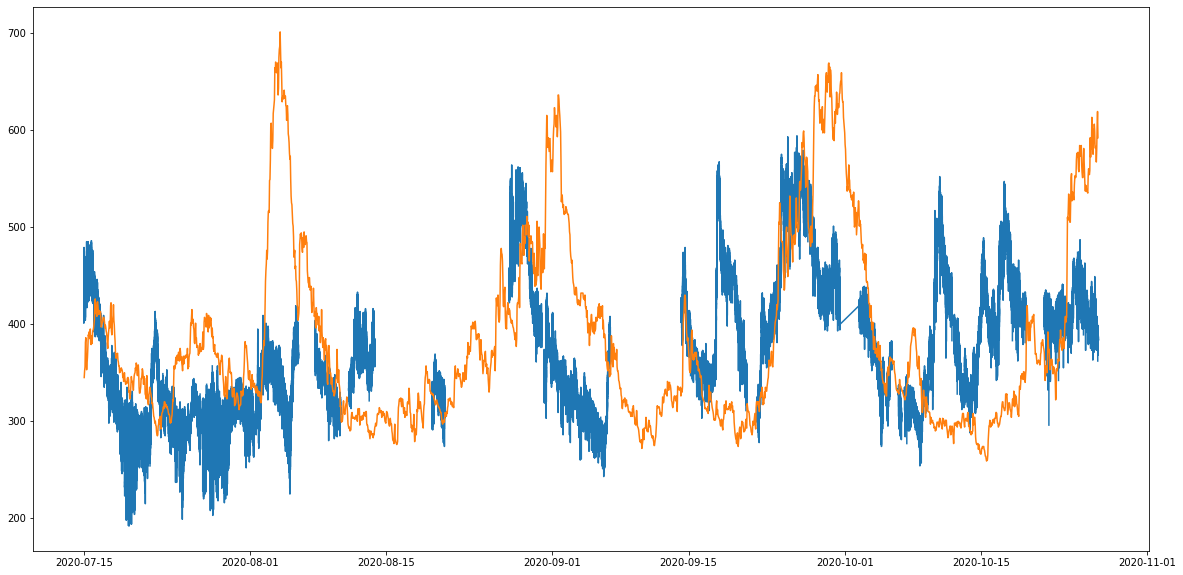

In [39]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(solo_data.index, solo_data.data["velocity_0"], label="Solar Orbiter")
plt.plot(omni_data.index, omni_data.data["V"], label="OMNI")